<a href="https://colab.research.google.com/github/VikashKumar-1996/Exploring-Polymer-Conformation-using-VAE/blob/main/polymer_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated 1000/10000 structures
Generated 2000/10000 structures
Generated 3000/10000 structures
Generated 4000/10000 structures
Generated 5000/10000 structures
Generated 6000/10000 structures
Generated 7000/10000 structures
Generated 8000/10000 structures
Generated 9000/10000 structures
Generated 10000/10000 structures
Saved internal coordinates to internal_coordinates.npy
Saved 10000 structures (cartesian coordinates) to dump_structures_coordinate.txt


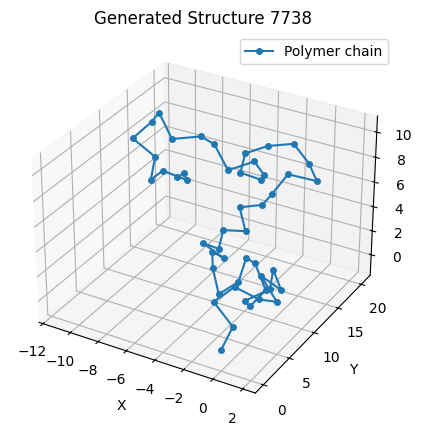

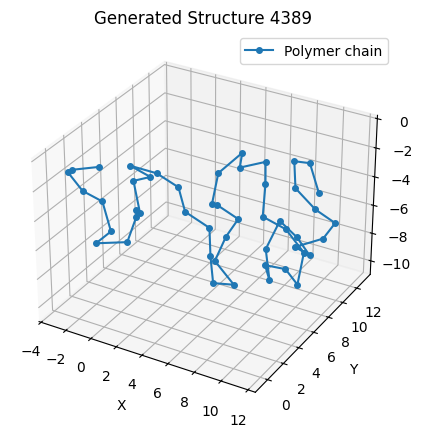

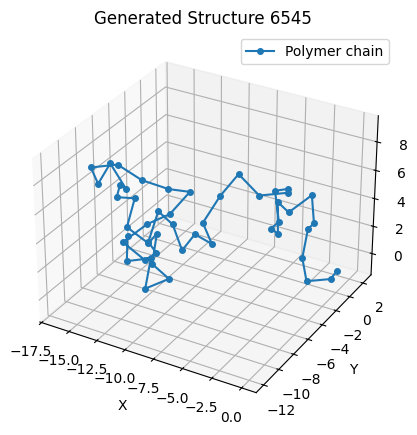

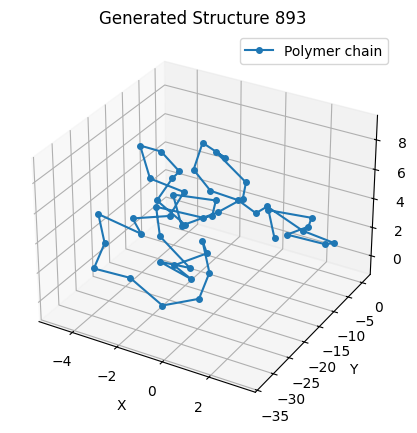

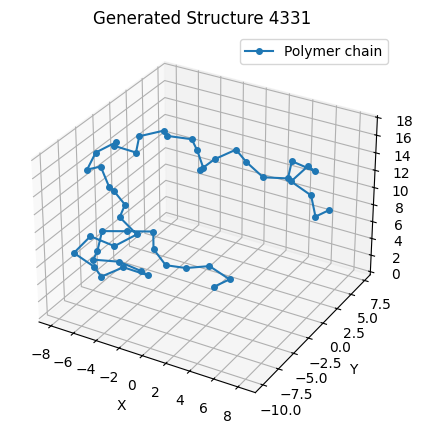


Analyzing distributions...


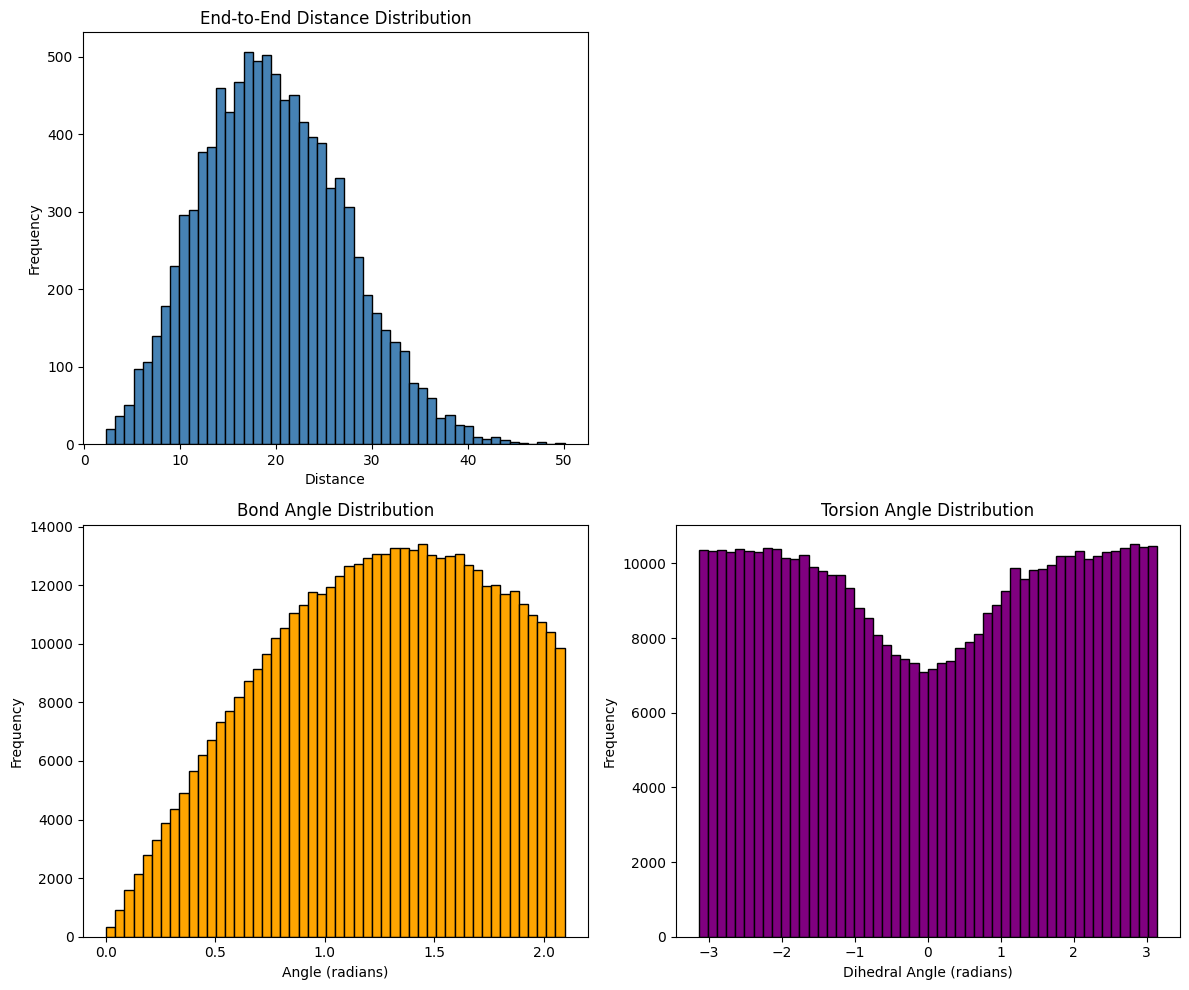

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def generate_off_lattice_saw(n_beads, bond_length, max_attempts=1000, max_restarts=100,
                             tol=1e-8, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    for restart in range(1, max_restarts + 1):
        positions = [np.array([0.0, 0.0, 0.0], dtype=float)]
        stuck = False

        for bead_index in range(1, n_beads):
            placed = False
            for attempt in range(max_attempts):
                direction = rng.normal(size=3)
                norm = np.linalg.norm(direction)
                if norm == 0:
                    continue
                direction /= norm
                next_pos = positions[-1] + bond_length * direction

                prev_positions = positions[:-1]
                if prev_positions:
                    diffs = np.array(prev_positions) - next_pos
                    dists = np.linalg.norm(diffs, axis=1)
                    if np.any(dists <= bond_length - tol):
                        continue

                positions.append(next_pos)
                placed = True
                break

            if not placed:
                stuck = True
                break

        if not stuck and len(positions) == n_beads:
            return np.array(positions)

    raise RuntimeError(f"Failed to generate SAW after {max_restarts} restarts (n_beads={n_beads}).")


def calculate_bond_lengths(positions):
    return np.linalg.norm(np.diff(positions, axis=0), axis=1)


def calculate_bond_angles(positions):
    bond_angles = []
    for i in range(1, len(positions) - 1):
        v1 = positions[i] - positions[i - 1]
        v2 = positions[i + 1] - positions[i]
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        if n1 == 0 or n2 == 0:
            bond_angles.append(0.0)
            continue
        cos_theta = np.dot(v1, v2) / (n1 * n2)
        bond_angles.append(np.arccos(np.clip(cos_theta, -1.0, 1.0)))
    return np.array(bond_angles)


def calculate_dihedral_angles(positions):
    torsional_angles = []
    for i in range(1, len(positions) - 2):
        v1 = positions[i] - positions[i - 1]
        v2 = positions[i + 1] - positions[i]
        v3 = positions[i + 2] - positions[i + 1]

        n1 = np.cross(v1, v2)
        n2 = np.cross(v2, v3)

        n1_norm = np.linalg.norm(n1)
        n2_norm = np.linalg.norm(n2)
        v2_norm = np.linalg.norm(v2)

        if n1_norm == 0 or n2_norm == 0 or v2_norm == 0:
            torsional_angles.append(0.0)
            continue

        cos_phi = np.dot(n1, n2) / (n1_norm * n2_norm)
        cos_phi = np.clip(cos_phi, -1.0, 1.0)
        sin_phi = np.dot(np.cross(n1, n2), v2) / (n1_norm * n2_norm * v2_norm)
        torsional_angles.append(np.arctan2(sin_phi, cos_phi))
    return np.array(torsional_angles)


def calculate_adjacency_matrix(positions, cutoff, include_bonds=True):
    n = len(positions)
    adjacency = np.zeros((n, n), dtype=int)
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    dists = np.linalg.norm(diff, axis=2)
    contacts = dists <= cutoff
    adjacency[contacts] = 1
    if not include_bonds:
        for i in range(n - 1):
            adjacency[i, i + 1] = 0
            adjacency[i + 1, i] = 0
    np.fill_diagonal(adjacency, 0)
    return adjacency


def plot_structure(positions, title="Polymer Conformation", show=True):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], '-o', markersize=4, label="Polymer chain")
    ax.set_title(title)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend()
    if show:
        plt.show()
    return fig, ax


def save_structures_to_xyz(path, structures):
    dirpath = os.path.dirname(path)
    if dirpath:
        os.makedirs(dirpath, exist_ok=True)
    with open(path, 'w') as f:
        for structure in structures:
            for bead in structure:
                f.write(f"{bead[0]:.8f} {bead[1]:.8f} {bead[2]:.8f}\n")
            f.write("\n")


def generate_and_save_dataset(n_structures=500, n_beads=50, bond_length=2.0,
                              cutoff_distance=None, output_file="dump_structures_coordinate.txt",
                              internal_coords_file="internal_coordinates.npy",
                              seed=None, max_attempts=1000, max_restarts=100):
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    if cutoff_distance is None:
        cutoff_distance = bond_length

    all_structures = []
    all_internal_coords = []
    for i in range(n_structures):
        positions = generate_off_lattice_saw(n_beads, bond_length, max_attempts=max_attempts,
                                            max_restarts=max_restarts, rng=rng)
        bond_lengths = calculate_bond_lengths(positions)
        bond_angles = calculate_bond_angles(positions)
        dihedral_angles = calculate_dihedral_angles(positions)

        internal_coords = np.concatenate([bond_lengths, bond_angles, dihedral_angles])
        all_internal_coords.append(internal_coords)
        all_structures.append(positions)

        if (i + 1) % max(1, n_structures // 10) == 0:
            print(f"Generated {i + 1}/{n_structures} structures")

    internal_dir = os.path.dirname(internal_coords_file)
    if internal_dir:
        os.makedirs(internal_dir, exist_ok=True)
    np.save(internal_coords_file, np.array(all_internal_coords))
    print(f"Saved internal coordinates to {internal_coords_file}")

    output_dir = os.path.dirname(output_file)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    save_structures_to_xyz(output_file, all_structures)
    print(f"Saved {len(all_structures)} structures (cartesian coordinates) to {output_file}")

    return all_structures, np.array(all_internal_coords)


if __name__ == "__main__":
    n_structures = 10000
    n_beads = 50
    bond_length = 2.0
    cutoff_distance = bond_length
    output_file = "dump_structures_coordinate.txt"
    internal_coords_file = "internal_coordinates.npy"

    structures, internal_coords = generate_and_save_dataset(
        n_structures=n_structures,
        n_beads=n_beads,
        bond_length=bond_length,
        cutoff_distance=cutoff_distance,
        output_file=output_file,
        internal_coords_file=internal_coords_file,
        seed=42,
        max_attempts=2000,
        max_restarts=200
    )

    # Plot a few example structures
    rng = np.random.default_rng(42)
    indices = rng.choice(len(structures), size=min(5, len(structures)), replace=False)
    for idx in indices:
        plot_structure(structures[idx], title=f"Generated Structure {idx+1}")

    # ==========================
    # Distribution Analysis
    # ==========================

    print("\nAnalyzing distributions...")

    # Flatten all bond lengths, angles, and dihedrals into single arrays
    all_bond_lengths = np.concatenate([calculate_bond_lengths(p) for p in structures])
    all_bond_angles = np.concatenate([calculate_bond_angles(p) for p in structures])
    all_dihedrals = np.concatenate([calculate_dihedral_angles(p) for p in structures])

    # End-to-end distances
    end_to_end = np.array([np.linalg.norm(p[-1] - p[0]) for p in structures])
  # Plot histograms (data in radians)
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.hist(end_to_end, bins=50, color='steelblue', edgecolor='black')
    plt.title("End-to-End Distance Distribution")
    plt.xlabel("Distance"); plt.ylabel("Frequency")



    plt.subplot(2, 2, 3)
    plt.hist(all_bond_angles, bins=50, color='orange', edgecolor='black')
    plt.title("Bond Angle Distribution")
    plt.xlabel("Angle (radians)"); plt.ylabel("Frequency")

    plt.subplot(2, 2, 4)
    plt.hist(all_dihedrals, bins=50, color='purple', edgecolor='black')
    plt.title("Torsion Angle Distribution")
    plt.xlabel("Dihedral Angle (radians)"); plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()



In [ ]:
data=np.load("internal_coordinates.npy")

In [ ]:
data[:1].shape

(1, 144)

In [ ]:
data[:1]

array([[ 2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
         2.        ,  2.        ,  2.        ,  2.        ,  1.15734799,
         0.49591436,  2.04866666,  2.08856646,  2.09232682,  1.37755332,
         1.31643003,  1.3732481 ,  2.00984777,  1.37145542,  1.01129951,
         1.82390296,  1.12945713,  1.45342946,  1.74942346,  1.919988  ,
         1.1386824 ,  0.81878798,  1.58620221,  1.2

In [ ]:
import numpy as np

# Load the uploaded .npy file
file_path = "internal_coordinates.npy"
data = np.load(file_path)

# Inspect its shape and basic stats
shape = data.shape
mean = np.mean(data)
std = np.std(data)
min_val = np.min(data)
max_val = np.max(data)

(shape, mean, std, min_val, max_val)


((10000, 144),
 np.float64(1.0943161818451814),
 np.float64(1.3879683263936904),
 np.float64(-3.1415566556181704),
 np.float64(3.141585936965449))

Epoch 1/500, Train Loss: 192.9510, Val Loss: 170.6839
Epoch 2/500, Train Loss: 147.2380, Val Loss: 128.6850
Epoch 3/500, Train Loss: 118.5756, Val Loss: 113.7203
Epoch 4/500, Train Loss: 108.6275, Val Loss: 107.7332
Epoch 5/500, Train Loss: 104.0640, Val Loss: 105.1070
Epoch 6/500, Train Loss: 102.3069, Val Loss: 103.6974
Epoch 7/500, Train Loss: 101.4680, Val Loss: 103.6811
Epoch 8/500, Train Loss: 100.7504, Val Loss: 102.9587
Epoch 9/500, Train Loss: 100.2169, Val Loss: 103.0781
Epoch 10/500, Train Loss: 99.6350, Val Loss: 103.0607
Epoch 11/500, Train Loss: 99.4990, Val Loss: 102.4024
Epoch 12/500, Train Loss: 99.1748, Val Loss: 102.7294
Epoch 13/500, Train Loss: 98.8678, Val Loss: 101.7966
Epoch 14/500, Train Loss: 98.6561, Val Loss: 101.5914
Epoch 15/500, Train Loss: 98.3189, Val Loss: 101.8001
Epoch 16/500, Train Loss: 98.3742, Val Loss: 101.8531
Epoch 17/500, Train Loss: 98.1149, Val Loss: 102.4757
Epoch 18/500, Train Loss: 97.8948, Val Loss: 102.1615
Epoch 19/500, Train Loss: 97

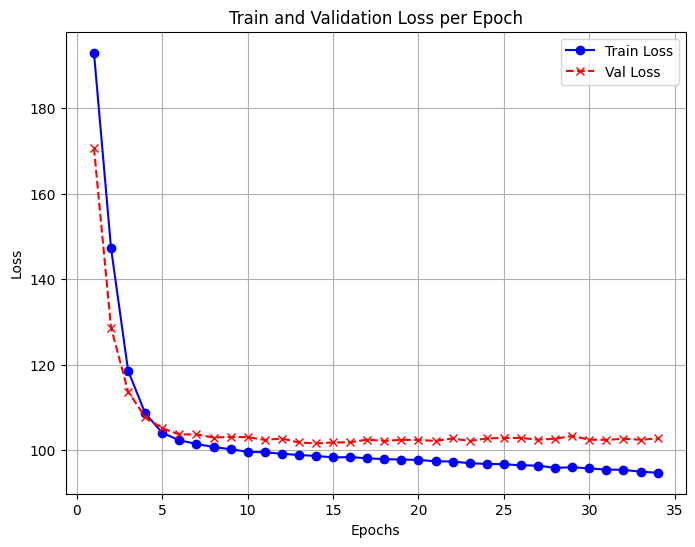

Test Loss: 102.5000


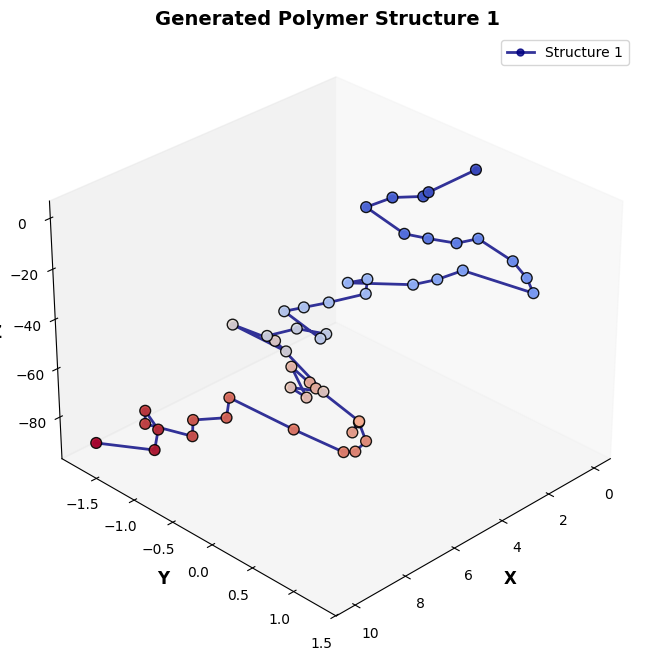

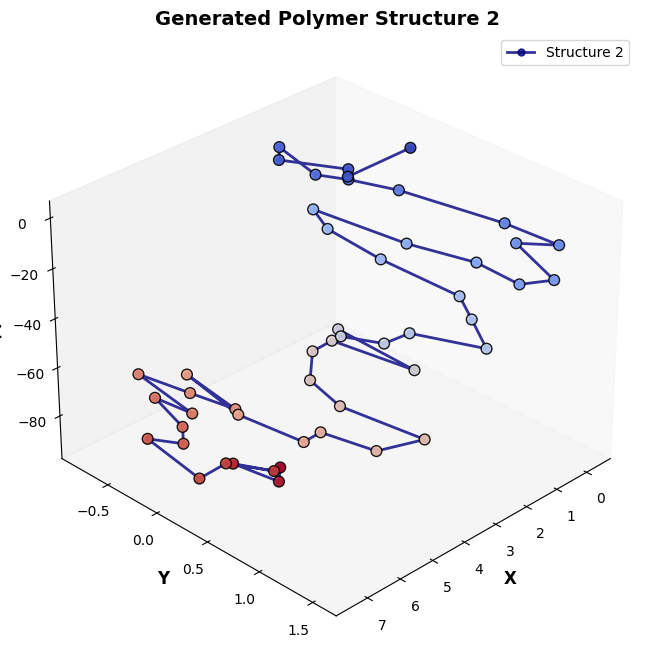

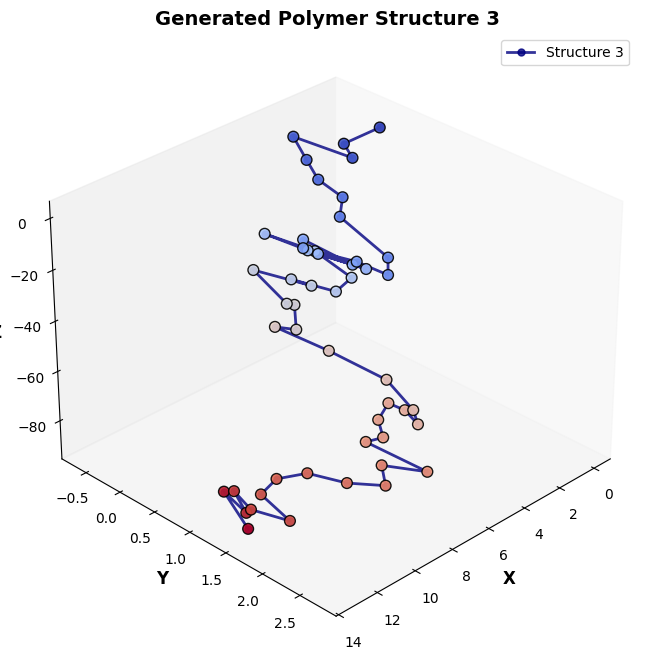

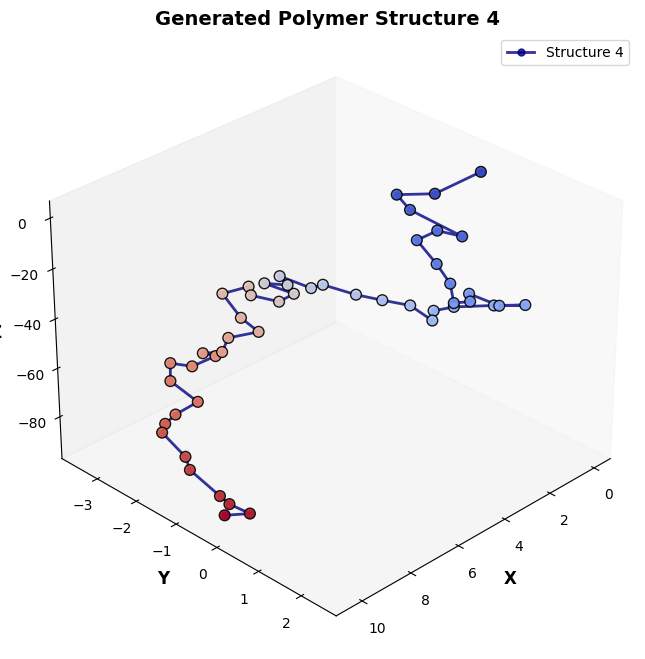

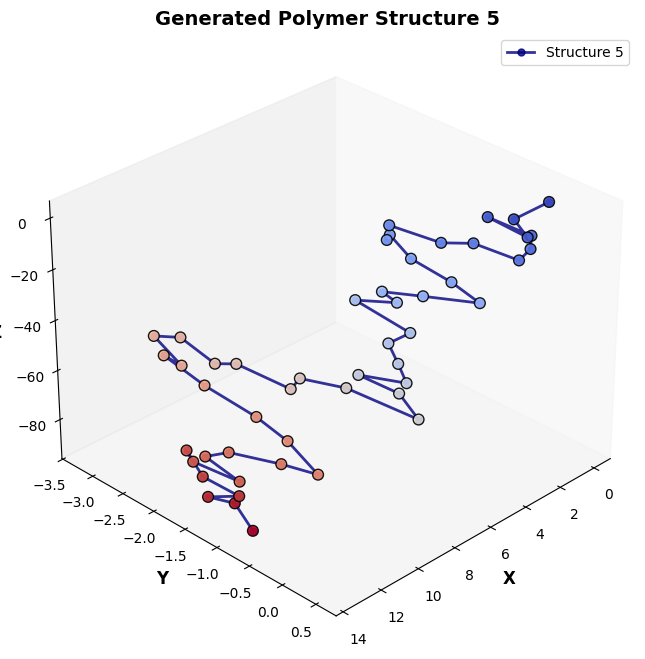

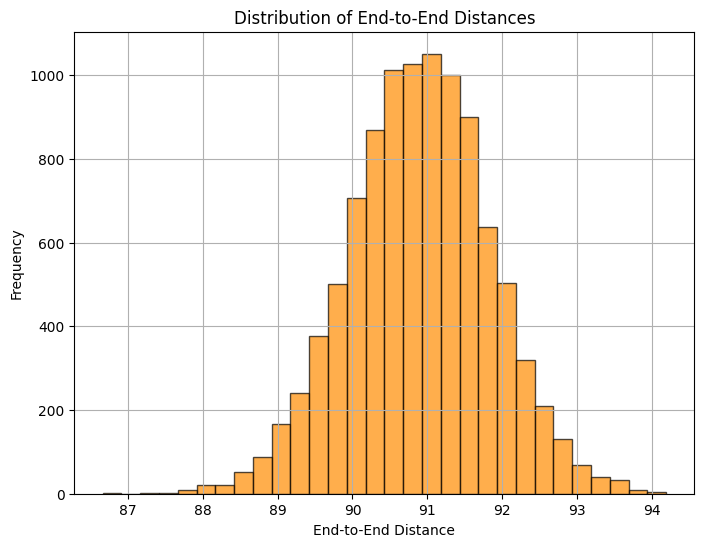

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# 1. Data Load
internal_coords = np.load("/content/internal_coordinates.npy")
X = torch.tensor(internal_coords, dtype=torch.float32)

# 2. Hyperparameters
latent_dim = 40
batch_size = 64
epochs = 500
patience = 20

# 3. VAE Definition
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, input_dim)
        )
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        return self.decoder(z)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 4. Loss function (Vanilla VAE)
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss(reduction='sum')(recon_x, x)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

# 5. Train / validation / test splits
dataset = TensorDataset(X)
n = len(dataset)
test_size = int(n * 0.1)
val_size = int(n * 0.1)
train_size = n - test_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 6. Init model and optimizer
model = VAE(input_dim=internal_coords.shape[1], latent_dim=latent_dim)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

best_loss = float('inf')
no_improvement = 0
train_losses = []
val_losses = []

# 7. Training loop
for epoch in range(epochs):
    # Train
    model.train()
    train_loss = 0
    for batch_idx, (data,) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (data,) in val_loader:
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        no_improvement = 0
        torch.save(model.state_dict(), 'best_vae_model.pth')
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f"No improvement for {patience} epochs, stopping training...")
            break

# 8. Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b', label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', linestyle='--', color='r', label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss per Epoch")
plt.grid(True)
plt.legend()
plt.show()

# 9. Evaluate on test set
model.load_state_dict(torch.load('best_vae_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for (data,) in test_loader:
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.4f}")

# 10. Generate new samples
num_samples = 10000
latent_samples = torch.randn(num_samples, latent_dim)
generated_internal_coords = model.decode(latent_samples).detach().cpu().numpy()

# 11. Convert internal to cartesian coordinates
def internal_to_cartesian(internal_coords, num_beads=50, bond_length=2.0):
    coords = np.zeros((num_beads, 3))
    bond_lengths = internal_coords[:num_beads - 1]
    bond_angles = internal_coords[num_beads - 1:num_beads - 1 + (num_beads - 2)]
    torsional_angles = internal_coords[num_beads - 1 + (num_beads - 2):]

    coords[1] = coords[0] + np.array([bond_length, 0, 0])
    for i in range(2, num_beads):
        bond_vec = np.array([bond_lengths[i - 1], 0, 0])
        rot_bond = R.from_euler('y', bond_angles[i - 2], degrees=False).as_matrix()
        rot_torsion = R.from_euler('z', torsional_angles[i - 3], degrees=False).as_matrix()
        bond_vec = rot_bond @ bond_vec
        bond_vec = rot_torsion @ bond_vec
        bond_vec = bond_length * bond_vec / np.linalg.norm(bond_vec)
        coords[i] = coords[i - 1] + bond_vec
    return coords

generated_cartesian_coords = [internal_to_cartesian(ic) for ic in generated_internal_coords]

# 12. Visualization: plot first N generated polymer structures
for i, coords in enumerate(generated_cartesian_coords[:5]):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], marker='o', linestyle='-', color="navy", markersize=5, linewidth=2, alpha=0.8, label=f'Structure {i + 1}')
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=np.linspace(0, 1, len(coords)), cmap='coolwarm', s=60, edgecolor='black', alpha=0.9)
    ax.set_xlabel('X', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y', fontsize=12, fontweight='bold')
    ax.set_zlabel('Z', fontsize=12, fontweight='bold')
    ax.set_title(f'Generated Polymer Structure {i + 1}', fontsize=14, fontweight='bold')
    ax.view_init(elev=30, azim=45)
    ax.grid(False)
    ax.legend(loc='upper right', fontsize=10)
    plt.show()

# 13. End-to-end distance distribution
def calculate_end_to_end_distances(cartesian_coords):
    return [np.linalg.norm(coords[-1] - coords[0]) for coords in cartesian_coords]

end_to_end_distances = calculate_end_to_end_distances(generated_cartesian_coords)
plt.figure(figsize=(8, 6))
plt.hist(end_to_end_distances, bins=30, color='darkorange', edgecolor='black', alpha=0.7)
plt.xlabel("End-to-End Distance")
plt.ylabel("Frequency")
plt.title("Distribution of End-to-End Distances")
plt.grid(True)
plt.show()
